# Trabajo Práctico - CEIA Vision por Computadora II

Alumno: Alianak, Juan Pablo

En este trabajo analizaremos el dataset Fruit. El dataset cuenta 3155 imagenes de 11 clases diferentes de frutas. 

El objetivo final será modelar un clasificador con redes convolucionales que sea capaz de, dada una imagen dentro de estas clases, predecir a cual de ellas pertenece.

Las noteboos estan divididas en 3 partes:

- VCP2-TP-Fruit

  En esta notebook implementaremos distintos modelos con y sin Data Aumentation para observar el comportamiento de cada uno de ellos.

- VCP2-TP-Fruit-Transfer_learning

  En esta notebook, con el modelo elegido en base al punto anterior, impplementaremos transfer lerning y evaluaremos resultados.

- VCP2-TP-Fruit-Optimization

  En esta notebook haremos optimizacion de algunos hiperparametros tomando como modelo el generado con trasfer learning.


### Importamos las librerias necesarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import subplot

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchsummary

import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset

from google.colab.patches import cv2_imshow 
import cv2
import pandas as pd

!pip install torchmetrics
import torchmetrics

from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 6.7 MB/s 


### Montamos el drive para acceder a los datos

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


### Carga de los nombres de las imagenes y de las clases

In [3]:
csv_train = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/train/classes.csv')
csv_valid = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/valid/classes.csv')
csv_test  = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/test/classes.csv')

## Analisis del dataset

In [4]:
csv_train.head()

,filename,label
0,248_jpg.rf.003489e160ccd8ccb87299874a2a2d67.jpg,Mango
1,351_jpg.rf.0041d4448efe427983229306a0fe4b74.jpg,Coconut
2,254_jpg.rf.00460c96b0897f30d9e7902dafd793ce.jpg,Banana
3,163_jpg.rf.00512d2303e2f92c60b2326ea1b29d62.jpg,Grape
4,251_jpg.rf.006e87af34b780c148c3edd359f5c98a.jpg,Star_Fruit


In [5]:
csv_train.describe()

,filename,label
count,1881,1881
unique,1881,11
top,248_jpg.rf.003489e160ccd8ccb87299874a2a2d67.jpg,Coconut
freq,1,240


In [6]:
print('Apple',csv_train['label'].value_counts()['Apple'])
print('Banana',csv_train['label'].value_counts()['Banana'])
print('Coconut',csv_train['label'].value_counts()['Coconut'])
print('Dragon',csv_train['label'].value_counts()['Dragon'])
print('Grape',csv_train['label'].value_counts()['Grape'])
print('Mango',csv_train['label'].value_counts()['Mango'])
print('Orange',csv_train['label'].value_counts()['Orange'])
print('Papaya',csv_train['label'].value_counts()['Papaya'])
print('Pineapple',csv_train['label'].value_counts()['Pineapple'])
print('Star_Fruit',csv_train['label'].value_counts()['Star_Fruit'])
print('Strawberry',csv_train['label'].value_counts()['Strawberry'])

Apple 201
Banana 220
Coconut 240
Dragon 115
Grape 176
Mango 112
Orange 189
Papaya 230
Pineapple 68
Star_Fruit 120
Strawberry 210


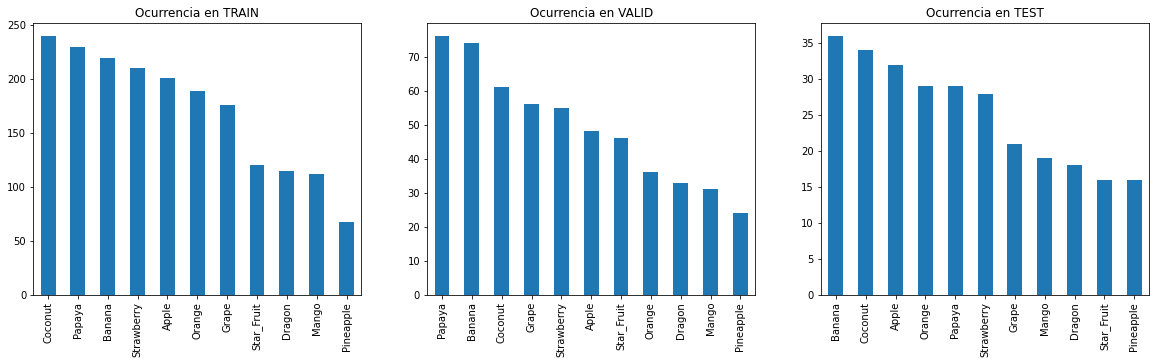

In [10]:
plt.figure(1,figsize=(20,5))
plt.subplot(1,3,1)
csv_train['label'].value_counts().plot(kind='bar')
plt.title('Ocurrencia en TRAIN')
plt.subplot(1,3,2)
csv_valid['label'].value_counts().plot(kind='bar')
plt.title('Ocurrencia en VALID')
plt.subplot(1,3,3)
csv_test['label'].value_counts().plot(kind='bar')
plt.title('Ocurrencia en TEST')
plt.show()

Observamos que el dataset presenta un aceptable balance de sus clases

## Preparacion y Generacion de los datos

In [ ]:
class ImageDataset(Dataset):
  def __init__(self,csv,img_folder,transform):
    self.csv=csv
    self.transform=transform
    self.img_folder=img_folder
    self.image_names=self.csv[:]['filename']
    #self.labels=np.array(self.csv.drop(['filename'], axis=1), dtype=float)
    self.class2index = {'Apple':0, 'Banana':1, 'Coconut':2, 'Dragon':3, 'Grape':4, 'Mango':5, 'Orange':6, 'Papaya':7, 'Pineapple':8, 'Star_Fruit':9, 'Strawberry':10}

  #The __len__ function returns the number of samples in our dataset.
  def __len__(self):
    return len(self.image_names)
 
  def __getitem__(self,index):
     
    image=cv2.imread(self.img_folder+self.image_names.iloc[index])
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
 
    image=self.transform(image)
    targets = self.class2index[self.csv.loc[index]['label']]

    return image, targets

In [ ]:
data_transforms = torchvision.transforms.Compose([
                    transforms.ToPILImage(),
                    torchvision.transforms.Resize(size=(150, 150)),
                    torchvision.transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                  ])

train_set = ImageDataset(csv=csv_train,img_folder='/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/train/',transform=data_transforms)
valid_set = ImageDataset(csv=csv_valid,img_folder='/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/valid/',transform=data_transforms)
test_set  = ImageDataset(csv=csv_test,img_folder='/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/test/',transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

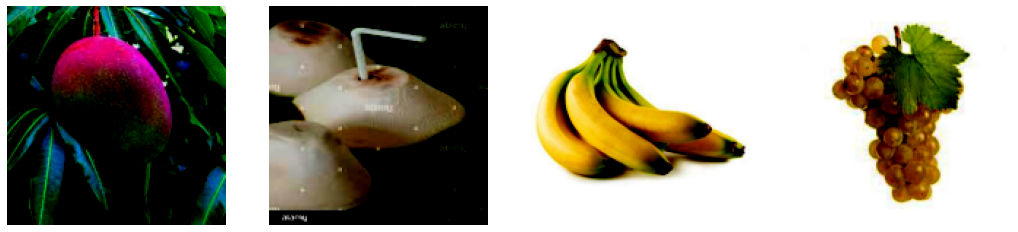

In [ ]:
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(train_set[id][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

## Implementacion de los modelos

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(device)

cuda


In [ ]:
model_resnet18 = torchvision.models.resnet18(weights=None, num_classes=11)
model_resnet50 = torchvision.models.resnet50(weights=None, num_classes=11)
model_vgg19 = torchvision.models.vgg19(weights=None, num_classes=11)
model_inceptionv3 = torchvision.models.inception_v3(weights=None, num_classes=11)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:47: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


In [ ]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):
  
  train_loss = []
  train_acc = []
  valid_loss = []
  valid_acc = []
  model = model.to(device=device) 
  
  for epoch in range(epochs):
    model.train()
    loss_var = 0
    epoch_train_loss = 0.0
    epoch_train_accuracy = 0.0

    for idx, (images, labels) in enumerate(train_loader):

        images = images.to(device=device)
        labels = labels.to(device=device)

        optimizer.zero_grad()
        # -------- Output for ResNet model ------------------
        #output = model(images)
        
        # -------- Output for Inception model ------------------
        output , _ = model(images)

        loss = criterion(output,labels)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        accuracy = conv_model_accuracy(output, labels)
        epoch_train_accuracy += accuracy.item()

    epoch_train_loss = epoch_train_loss / len(train_loader)
    epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_accuracy)

    epoch_valid_loss = 0.0
    epoch_valid_accuracy = 0.0

    with torch.no_grad():
        model.eval()
        correct = 0
        samples = 0
        for idx, (images, labels) in enumerate(valid_loader):
            images = images.to(device=device)
            labels = labels.to(device=device)
            output = model(images)
            epoch_valid_loss += criterion(output, labels).item()
            epoch_valid_accuracy += conv_model_accuracy(output, labels).item()
      
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)
       
    print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
    epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

  return model, history

In [ ]:
criterion = nn.CrossEntropyLoss()
conv_model_accuracy = torchmetrics.Accuracy()
conv_model_accuracy.to(device=device)

Accuracy()

In [ ]:
def ploteo(history):
  fig, axs = plt.subplots(2, 1, figsize=(15,15))
  axs[0].plot(history['train_loss']) 
  axs[0].plot(history['valid_loss']) 
  axs[0].title.set_text('Error de Entrenamiento vs Validación') 
  axs[0].legend(['Train', 'Valid'])  
  axs[1].plot(history['train_acc']) 
  axs[1].plot(history['valid_acc'])
  axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
  axs[1].legend(['Train', 'Valid'])

In [ ]:
def test(model, criterion, test_loader):

  test_loss = 0.0
  test_accuracy = 0.0

  for test_data, test_target in test_loader:
    if torch.cuda.is_available():
          test_data, test_target = test_data.cuda(), test_target.cuda()
    output = model(test_data)
    test_loss += criterion(output, test_target).item()
    test_accuracy += conv_model_accuracy(output, test_target).item()

  test_loss = test_loss / len(test_loader)
  test_accuracy = test_accuracy / len(test_loader)

  print("El modelo logro un error de TETS de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))

Epoch: 1/20 - Train loss 1.755036 - Train Accuracy 0.394258 - Valid Loss 2.299357 - Valid Accuracy 0.367647
Epoch: 2/20 - Train loss 1.490096 - Train Accuracy 0.467203 - Valid Loss 1.647358 - Valid Accuracy 0.387342
Epoch: 3/20 - Train loss 1.427127 - Train Accuracy 0.483771 - Valid Loss 1.568318 - Valid Accuracy 0.432248
Epoch: 4/20 - Train loss 1.329399 - Train Accuracy 0.510318 - Valid Loss 1.694932 - Valid Accuracy 0.428571
Epoch: 5/20 - Train loss 1.228141 - Train Accuracy 0.568750 - Valid Loss 1.672883 - Valid Accuracy 0.422794
Epoch: 6/20 - Train loss 1.208614 - Train Accuracy 0.567987 - Valid Loss 1.500150 - Valid Accuracy 0.477679
Epoch: 7/20 - Train loss 1.155547 - Train Accuracy 0.607331 - Valid Loss 1.232549 - Valid Accuracy 0.535452
Epoch: 8/20 - Train loss 1.037179 - Train Accuracy 0.636907 - Valid Loss 1.303162 - Valid Accuracy 0.538603
Epoch: 9/20 - Train loss 0.997082 - Train Accuracy 0.653093 - Valid Loss 1.148684 - Valid Accuracy 0.588498
Epoch: 10/20 - Train loss 0.

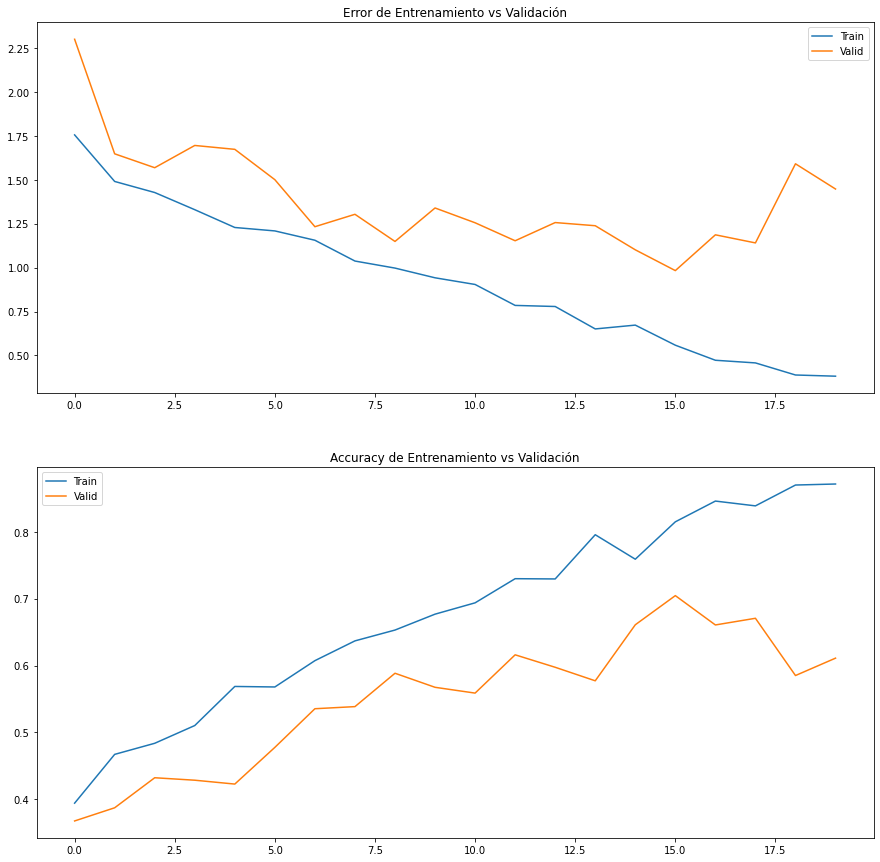

In [ ]:
optimizer_resnet18 = torch.optim.Adam(model_resnet18.parameters(), lr= 0.001)
result_model_resnet18, history_resnet18 = train(model_resnet18, criterion, optimizer_resnet18, train_loader, valid_loader, 20)
ploteo(history_resnet18)
test(model_resnet18, criterion, test_loader)

Epoch: 1/20 - Train loss 2.141935 - Train Accuracy 0.310127 - Valid Loss 1.851502 - Valid Accuracy 0.353729
Epoch: 2/20 - Train loss 1.631677 - Train Accuracy 0.422860 - Valid Loss 2.518582 - Valid Accuracy 0.407300
Epoch: 3/20 - Train loss 1.537805 - Train Accuracy 0.467585 - Valid Loss 1.655261 - Valid Accuracy 0.416754
Epoch: 4/20 - Train loss 1.391464 - Train Accuracy 0.504343 - Valid Loss 1.404860 - Valid Accuracy 0.528887
Epoch: 5/20 - Train loss 1.361763 - Train Accuracy 0.532881 - Valid Loss 1.414364 - Valid Accuracy 0.457983
Epoch: 6/20 - Train loss 1.330536 - Train Accuracy 0.558771 - Valid Loss 1.464182 - Valid Accuracy 0.504464
Epoch: 7/20 - Train loss 1.190000 - Train Accuracy 0.594470 - Valid Loss 1.433076 - Valid Accuracy 0.495273
Epoch: 8/20 - Train loss 1.131875 - Train Accuracy 0.623284 - Valid Loss 1.086651 - Valid Accuracy 0.631303
Epoch: 9/20 - Train loss 1.035567 - Train Accuracy 0.659386 - Valid Loss 1.096243 - Valid Accuracy 0.637605
Epoch: 10/20 - Train loss 1.

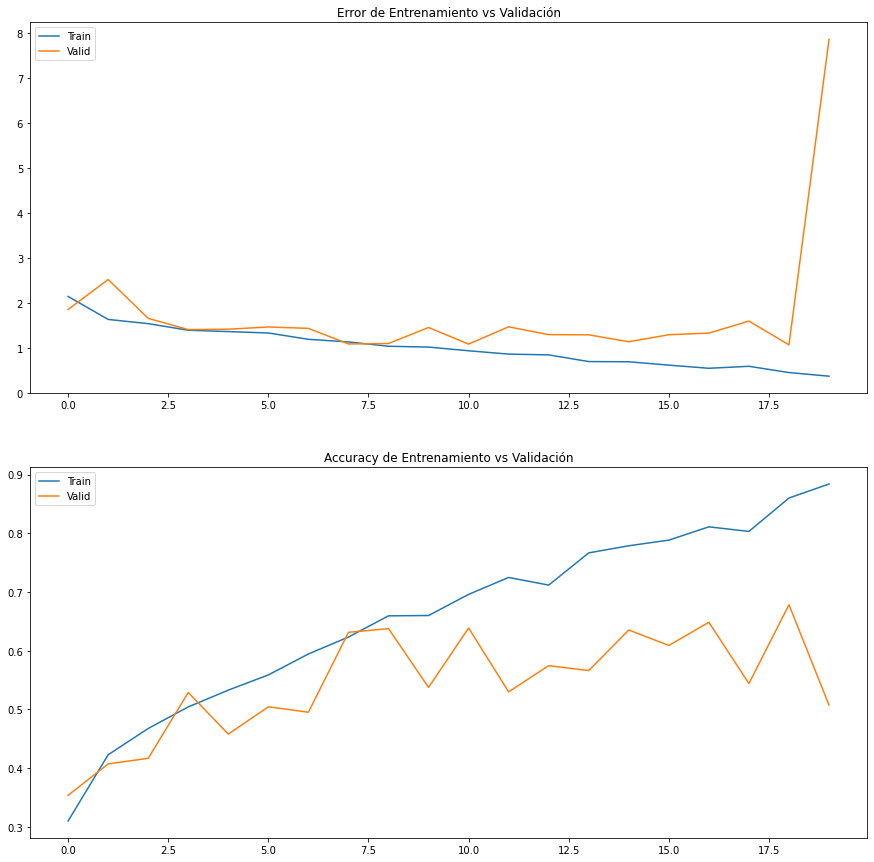

In [ ]:
optimizer_resnet50 = torch.optim.Adam(model_resnet50.parameters(), lr= 0.001)
result_model_resnet50, history_resnet50 = train(model_resnet50, criterion, optimizer_resnet50, train_loader, valid_loader, 20)
ploteo(history_resnet50)
test(model_resnet50, criterion, test_loader)

In [ ]:
data_transforms = torchvision.transforms.Compose([
                    transforms.ToPILImage(),
                    torchvision.transforms.Resize(size=(299, 299)),
                    torchvision.transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                  ])

train_set = ImageDataset(csv=csv_train,img_folder='/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/train/',transform=data_transforms)
valid_set = ImageDataset(csv=csv_valid,img_folder='/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/valid/',transform=data_transforms)
test_set  = ImageDataset(csv=csv_test,img_folder='/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/test/',transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

Epoch: 1/20 - Train loss 2.478858 - Train Accuracy 0.337881 - Valid Loss 1.519156 - Valid Accuracy 0.488445
Epoch: 2/20 - Train loss 1.534380 - Train Accuracy 0.532945 - Valid Loss 1.270341 - Valid Accuracy 0.555672
Epoch: 3/20 - Train loss 1.281968 - Train Accuracy 0.604682 - Valid Loss 1.199698 - Valid Accuracy 0.604254
Epoch: 4/20 - Train loss 1.109137 - Train Accuracy 0.645826 - Valid Loss 1.194848 - Valid Accuracy 0.594800
Epoch: 5/20 - Train loss 1.209864 - Train Accuracy 0.636081 - Valid Loss 1.173031 - Valid Accuracy 0.619485
Epoch: 6/20 - Train loss 1.117090 - Train Accuracy 0.672606 - Valid Loss 3.314006 - Valid Accuracy 0.523109
Epoch: 7/20 - Train loss 1.146883 - Train Accuracy 0.652564 - Valid Loss 1.144920 - Valid Accuracy 0.646534
Epoch: 8/20 - Train loss 0.938272 - Train Accuracy 0.706504 - Valid Loss 0.935479 - Valid Accuracy 0.678834
Epoch: 9/20 - Train loss 0.820487 - Train Accuracy 0.750021 - Valid Loss 0.906754 - Valid Accuracy 0.669118
Epoch: 10/20 - Train loss 0.

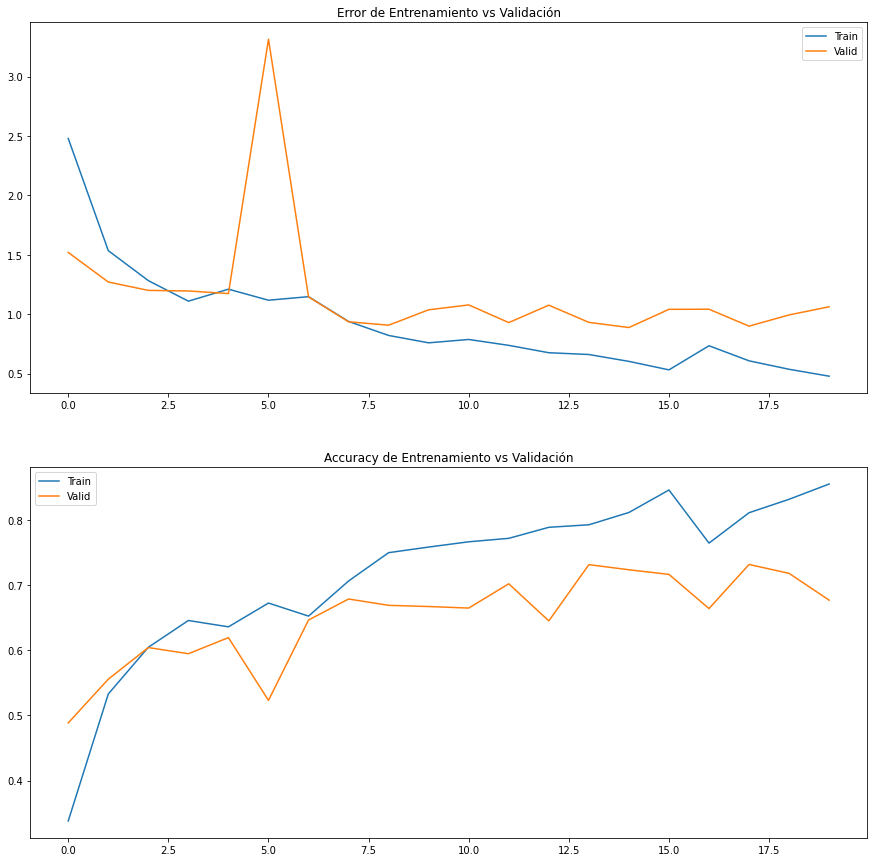

In [ ]:
optimizer_inceptionv3 = torch.optim.Adam(model_inceptionv3.parameters(), lr= 0.001)
result_model_inceptionv3, history_inceptionv3 = train(model_inceptionv3, criterion, optimizer_inceptionv3, train_loader, valid_loader, 20)
ploteo(history_inceptionv3)
test(model_inceptionv3, criterion, test_loader)

## Preparacion y Generacion de los datos con Data Aumentation

In [ ]:
aud_data_transforms = torchvision.transforms.Compose([
                        transforms.ToPILImage(),
                        torchvision.transforms.Resize(size=(150, 150)),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(150, 150), scale=(0.5, 1.0)),
                        torchvision.transforms.ColorJitter(saturation=0.05, hue=0.05),
                        torchvision.transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                      ])

train_set_aum = ImageDataset(csv=csv_train,img_folder='/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/train/',transform=aud_data_transforms)
valid_set_aum = ImageDataset(csv=csv_valid,img_folder='/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/valid/',transform=aud_data_transforms)
test_set_aum  = ImageDataset(csv=csv_test,img_folder='/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/test/',transform=aud_data_transforms)

train_loader_aum = torch.utils.data.DataLoader(train_set_aum, batch_size=32, shuffle=True)
valid_loader_aum = torch.utils.data.DataLoader(valid_set_aum, batch_size=32, shuffle=True)
test_loader_aum  = torch.utils.data.DataLoader(test_set_aum, batch_size=32, shuffle=True)

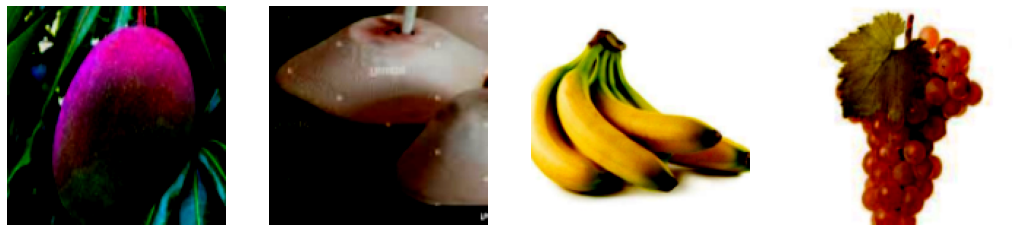

In [ ]:
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(train_set_aum[id][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

Epoch: 1/20 - Train loss 1.909758 - Train Accuracy 0.323517 - Valid Loss 1.901566 - Valid Accuracy 0.319590
Epoch: 2/20 - Train loss 1.663681 - Train Accuracy 0.412415 - Valid Loss 1.708470 - Valid Accuracy 0.374737
Epoch: 3/20 - Train loss 1.605165 - Train Accuracy 0.410996 - Valid Loss 1.666297 - Valid Accuracy 0.424632
Epoch: 4/20 - Train loss 1.509877 - Train Accuracy 0.482564 - Valid Loss 2.066700 - Valid Accuracy 0.294118
Epoch: 5/20 - Train loss 1.451003 - Train Accuracy 0.500042 - Valid Loss 1.523017 - Valid Accuracy 0.480830
Epoch: 6/20 - Train loss 1.335732 - Train Accuracy 0.538475 - Valid Loss 2.049598 - Valid Accuracy 0.398372
Epoch: 7/20 - Train loss 1.421172 - Train Accuracy 0.524407 - Valid Loss 1.924094 - Valid Accuracy 0.369748
Epoch: 8/20 - Train loss 1.291813 - Train Accuracy 0.558369 - Valid Loss 1.575770 - Valid Accuracy 0.486082
Epoch: 9/20 - Train loss 1.284687 - Train Accuracy 0.550212 - Valid Loss 1.595258 - Valid Accuracy 0.479517
Epoch: 10/20 - Train loss 1.

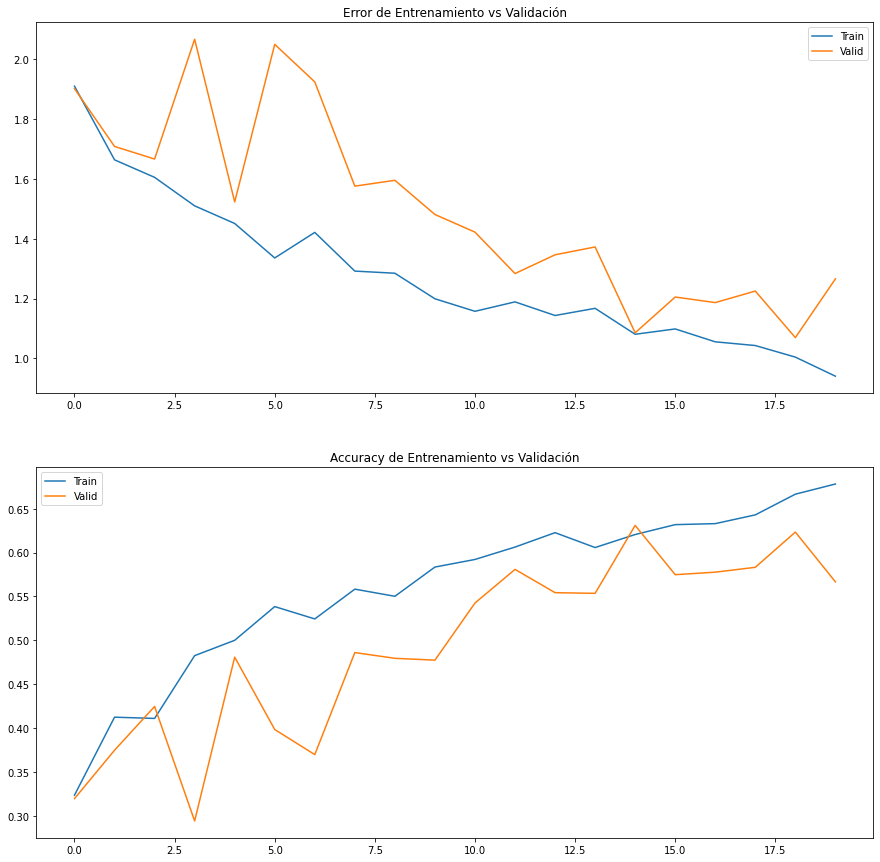

In [ ]:
optimizer_resnet18 = torch.optim.Adam(model_resnet18.parameters(), lr= 0.001)
result_model_resnet18_aum, history_resnet18_aum = train(model_resnet18, criterion, optimizer_resnet18, train_loader_aum, valid_loader_aum, 20)
ploteo(history_resnet18_aum)
test(model_resnet18, criterion, test_loader_aum)

Epoch: 1/20 - Train loss 2.221061 - Train Accuracy 0.265869 - Valid Loss 3.865077 - Valid Accuracy 0.259454
Epoch: 2/20 - Train loss 1.854785 - Train Accuracy 0.352352 - Valid Loss 21.106232 - Valid Accuracy 0.266282
Epoch: 3/20 - Train loss 1.759043 - Train Accuracy 0.386081 - Valid Loss 1.727715 - Valid Accuracy 0.398109
Epoch: 4/20 - Train loss 1.719707 - Train Accuracy 0.389513 - Valid Loss 1.837201 - Valid Accuracy 0.381303
Epoch: 5/20 - Train loss 1.642060 - Train Accuracy 0.412288 - Valid Loss 1.648963 - Valid Accuracy 0.461922
Epoch: 6/20 - Train loss 1.594551 - Train Accuracy 0.441250 - Valid Loss 1.580065 - Valid Accuracy 0.444065
Epoch: 7/20 - Train loss 1.562509 - Train Accuracy 0.444195 - Valid Loss 1.554176 - Valid Accuracy 0.451943
Epoch: 8/20 - Train loss 1.511003 - Train Accuracy 0.464407 - Valid Loss 1.492697 - Valid Accuracy 0.452206
Epoch: 9/20 - Train loss 1.458333 - Train Accuracy 0.462881 - Valid Loss 1.447020 - Valid Accuracy 0.464811
Epoch: 10/20 - Train loss 1

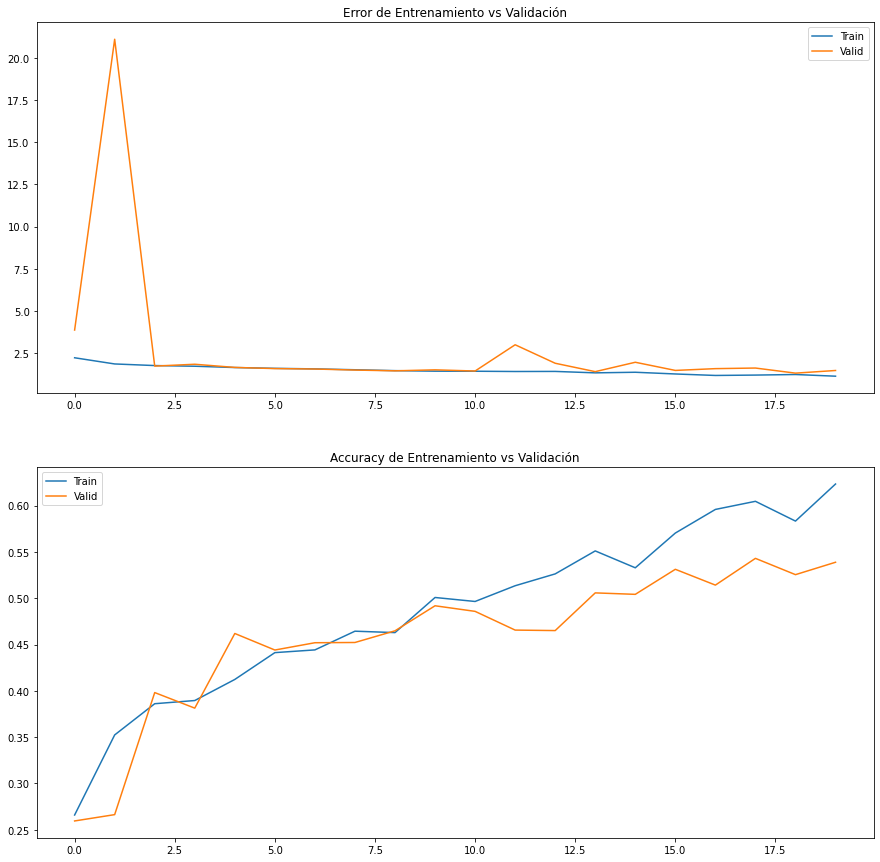

In [ ]:
optimizer_resnet50 = torch.optim.Adam(model_resnet50.parameters(), lr= 0.001)
result_model_resnet50_aum, history_resnet50_aum = train(model_resnet50, criterion, optimizer_resnet50, train_loader_aum, valid_loader_aum, 20)
ploteo(history_resnet50_aum)
test(model_resnet50, criterion, test_loader_aum)

In [ ]:
aud_data_transforms = torchvision.transforms.Compose([
                        transforms.ToPILImage(),
                        torchvision.transforms.Resize(size=(299, 299)),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(299, 299), scale=(0.5, 1.0)),
                        torchvision.transforms.ColorJitter(saturation=0.05, hue=0.05),
                        torchvision.transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                      ])

train_set_aum = ImageDataset(csv=csv_train,img_folder='/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/train/',transform=aud_data_transforms)
valid_set_aum = ImageDataset(csv=csv_valid,img_folder='/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/valid/',transform=aud_data_transforms)
test_set_aum  = ImageDataset(csv=csv_test,img_folder='/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/test/',transform=aud_data_transforms)

train_loader_aum = torch.utils.data.DataLoader(train_set_aum, batch_size=32, shuffle=True)
valid_loader_aum = torch.utils.data.DataLoader(valid_set_aum, batch_size=32, shuffle=True)
test_loader_aum  = torch.utils.data.DataLoader(test_set_aum, batch_size=32, shuffle=True)

Epoch: 1/20 - Train loss 3.017027 - Train Accuracy 0.317775 - Valid Loss 2.251138 - Valid Accuracy 0.398897
Epoch: 2/20 - Train loss 2.099933 - Train Accuracy 0.435869 - Valid Loss 2.486522 - Valid Accuracy 0.428834
Epoch: 3/20 - Train loss 1.863137 - Train Accuracy 0.464258 - Valid Loss 1.745647 - Valid Accuracy 0.522321
Epoch: 4/20 - Train loss 1.673912 - Train Accuracy 0.521377 - Valid Loss 2.252641 - Valid Accuracy 0.530200
Epoch: 5/20 - Train loss 1.600498 - Train Accuracy 0.541653 - Valid Loss 1.915742 - Valid Accuracy 0.551996
Epoch: 6/20 - Train loss 1.361882 - Train Accuracy 0.572161 - Valid Loss 1.552493 - Valid Accuracy 0.515231
Epoch: 7/20 - Train loss 1.289396 - Train Accuracy 0.583178 - Valid Loss 1.219671 - Valid Accuracy 0.579569
Epoch: 8/20 - Train loss 1.327888 - Train Accuracy 0.567903 - Valid Loss 1.405746 - Valid Accuracy 0.555672
Epoch: 9/20 - Train loss 1.202263 - Train Accuracy 0.616631 - Valid Loss 1.232167 - Valid Accuracy 0.585084
Epoch: 10/20 - Train loss 1.

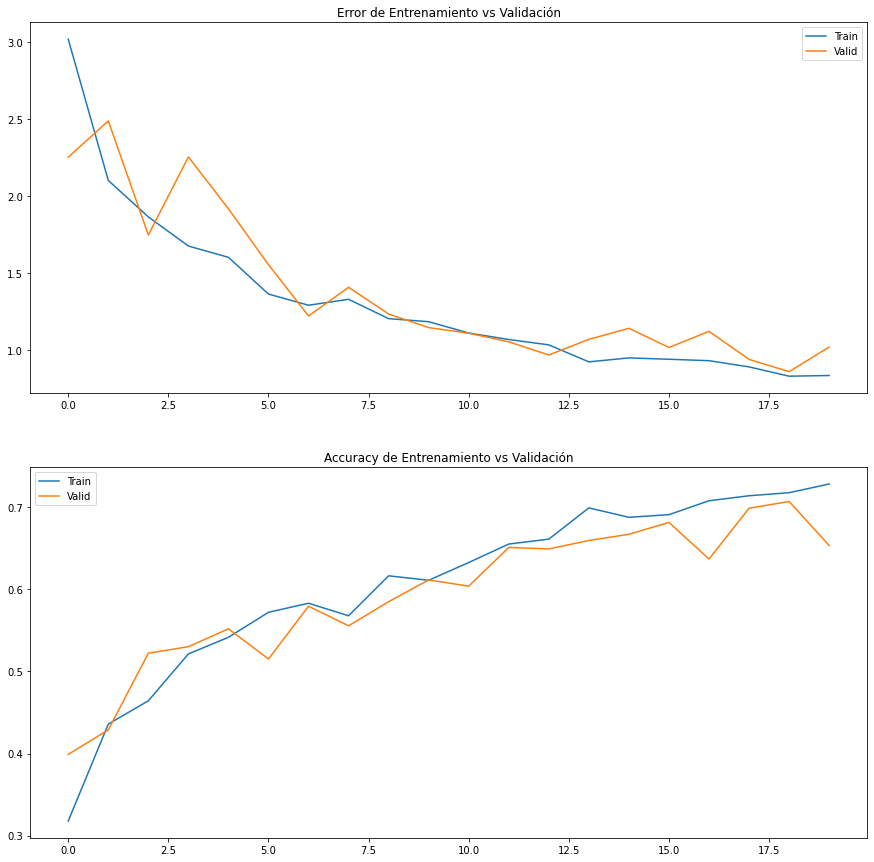

In [ ]:
optimizer_inceptionv3 = torch.optim.Adam(model_inceptionv3.parameters(), lr= 0.001)
result_model_inceptionv3_aum, history_inceptionv3_aum = train(model_inceptionv3, criterion, optimizer_inceptionv3, train_loader_aum, valid_loader_aum, 20)
ploteo(history_inceptionv3_aum)
test(model_inceptionv3, criterion, test_loader_aum)